In [1]:
import numpy as np
import os
from skimage.transform import estimate_transform, warp
import cv2
from predictor import PosPrediction
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

## 检测人脸
用于裁剪图像作为网络输入

In [2]:
## 预检测人脸框或者关键点，目的是裁剪人脸
cas = cv2.CascadeClassifier('./Data/cv-data/haarcascade_frontalface_alt2.xml')

In [3]:
img = plt.imread('./images/zly.jpg')
img_gray= cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
faces = cas.detectMultiScale(img_gray,2,3,0,(30,30))
bbox = np.array([faces[0,0],faces[0,1],faces[0,0]+faces[0,2],faces[0,1]+faces[0,3]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 207.5, 218.5, -0.5)

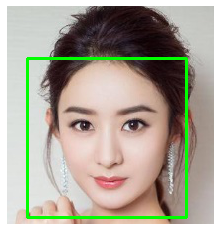

In [27]:
plt.imshow(cv2.rectangle(img.copy(),(bbox[0],bbox[1]),(bbox[2],bbox[3]),(0,255,0),2))
plt.axis('off')

In [5]:
left = bbox[0]; top = bbox[1]; right = bbox[2]; bottom = bbox[3]
old_size = (right - left + bottom - top)/2
center = np.array([right - (right - left) / 2.0, bottom - (bottom - top) / 2.0])
size = int(old_size*1.6)

In [6]:
src_pts = np.array([[center[0]-size/2, center[1]-size/2], 
                    [center[0] - size/2, center[1]+size/2], 
                    [center[0]+size/2, center[1]-size/2]])
DST_PTS = np.array([[0,0], [0,255], [255, 0]])
tform = estimate_transform('similarity', src_pts, DST_PTS)

img = img/255.
cropped_img = warp(img, tform.inverse, output_shape=(256, 256))

(-0.5, 255.5, 255.5, -0.5)

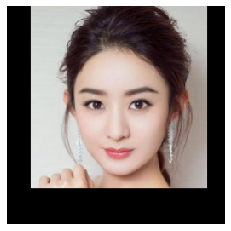

In [28]:
plt.imshow(cropped_img)
plt.axis('off')

## 网络推断
求解论文的 UV position map，然后重新调整到图像未被裁剪之前

In [8]:
pos_predictor = PosPrediction(256, 256)
pos_predictor.restore('./Data/net-data/256_256_resfcn256_weight')





Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./Data/net-data/256_256_resfcn256_weight


In [9]:
cropped_pos = pos_predictor.predict(cropped_img) #网络推断

In [10]:
#将裁剪图的结果重新调整
cropped_vertices = np.reshape(cropped_pos, [-1, 3]).T
z = cropped_vertices[2,:].copy()/tform.params[0,0]
cropped_vertices[2,:] = 1
vertices = np.dot(np.linalg.inv(tform.params), cropped_vertices)
vertices = np.vstack((vertices[:2,:], z))
pos = np.reshape(vertices.T, [256, 256, 3])

(-0.5, 255.5, 255.5, -0.5)

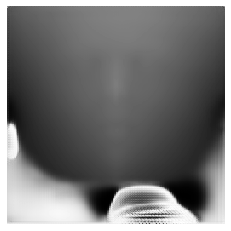

In [35]:
plt.imshow(pos[...,2],cmap='gray')
plt.axis('off')

## 人脸关键点
根据uv_kpt_ind从结果图中提取人脸关键点

In [11]:
def draw_kps(img,kps,point_size=2):
    img = np.array(img*255,np.uint8)
    for i in range(kps.shape[0]):
        cv2.circle(img,(int(kps[i,0]),int(kps[i,1])),point_size,(0,255,0),-1)
    return img

In [12]:
uv_kpt_ind = np.loadtxt('./Data/uv-data/uv_kpt_ind.txt').astype(np.int32)
face_kps = pos[uv_kpt_ind[1,:],uv_kpt_ind[0,:],:]

(-0.5, 207.5, 218.5, -0.5)

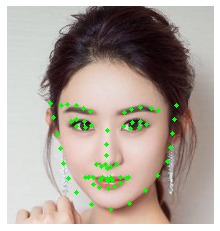

In [39]:
plt.imshow(draw_kps(img.copy(),face_kps))
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

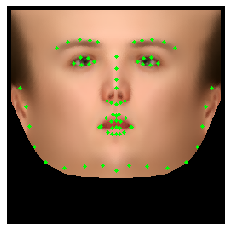

In [38]:
uv_face = plt.imread('./Data/uv-data/uv_face.png')
plt.imshow(draw_kps(uv_face,uv_kpt_ind.T))
plt.axis('off')

## 人脸点云
根据face_ind从结果图中提取人脸点云

In [14]:
face_ind = np.loadtxt('./Data/uv-data/face_ind.txt').astype(np.int32)
all_vertices = np.reshape(pos, [256*256, -1])
vertices = all_vertices[face_ind, :]

(-0.5, 207.5, 218.5, -0.5)

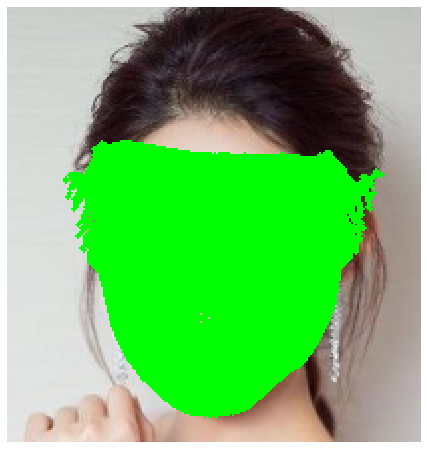

In [42]:
plt.figure(figsize=(8,8))
plt.imshow(draw_kps(img.copy(),vertices[:,:2],1))
plt.axis('off')

Text(0.5, 0, 'Z Label')

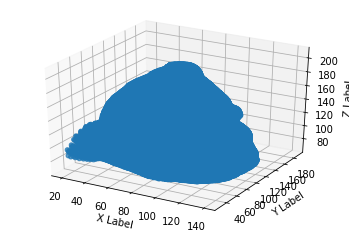

In [16]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax1 = plt.axes(projection='3d')
ax1.scatter3D(vertices[:,2],vertices[:,0],vertices[:,1], cmap='Blues')  #绘制散点图
ax1.set_xlabel('X Label') 
ax1.set_ylabel('Y Label') 
ax1.set_zlabel('Z Label') 

## 纹理图
通过 UV position map结果，从原img中获取texture图

In [17]:
texture = cv2.remap(img, pos[:,:,:2].astype(np.float32), None, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT,borderValue=(0))

(-0.5, 255.5, 255.5, -0.5)

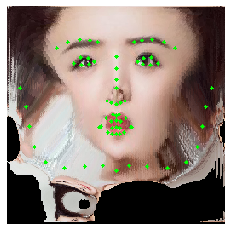

In [44]:
plt.imshow(draw_kps(texture,uv_kpt_ind.T))
plt.axis('off')

## 渲染/UV贴图
根据顶点和纹理渲染3D人脸图像，三角剖分每个三角区域着色

In [19]:
#找到每个三角形每个顶点的肤色
triangles = np.loadtxt('./Data/uv-data/triangles.txt').astype(np.int32)
all_colors = np.reshape(texture, [256*256, -1])
colors = all_colors[face_ind, :]

In [20]:
print(vertices.shape) # texutre每个像素对应的3D坐标
print(triangles.shape) #每个三角网格对应的像素索引
print(colors.shape) #每个三角形的颜色

(43867, 3)
(86906, 3)
(43867, 3)


In [21]:
#获取三角形每个顶点的depth，平均值作为三角形高度
tri_depth = (vertices[triangles[:,0],2 ] + vertices[triangles[:,1],2] + vertices[triangles[:,2],2])/3. 
#获取三角形每个顶点的color，平均值作为三角形颜色
tri_tex = (colors[triangles[:,0] ,:] + colors[triangles[:,1],:] + colors[triangles[:,2],:])/3.
tri_tex = tri_tex*255

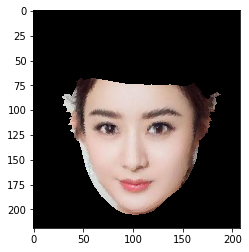

In [22]:
img_3D = np.zeros_like(img,dtype=np.uint8)
for i in range(triangles.shape[0]):
    cnt = np.array([(vertices[triangles[i,0],0],vertices[triangles[i,0],1]),
           (vertices[triangles[i,1],0],vertices[triangles[i,1],1]),
           (vertices[triangles[i,2],0],vertices[triangles[i,2],1])],dtype=np.int32)
    img_3D = cv2.drawContours(img_3D,[cnt],0,tri_tex[i],-1)
plt.imshow(img_3D/255.0)

## 旋转3D图
通过3D顶点坐标和人脸texture对原图进行旋转

In [23]:
# 找到旋转矩阵，参考https://github.com/YadiraF/face3d
def angle2matrix(angles):
    x, y, z = np.deg2rad(angles[0]), np.deg2rad(angles[1]), np.deg2rad(angles[2])
    # x
    Rx=np.array([[1,              0,                0],
                 [0, np.math.cos(x),  -np.math.sin(x)],
                 [0, np.math.sin(x),   np.math.cos(x)]])
    # y
    Ry=np.array([[ np.math.cos(y), 0, np.math.sin(y)],
                 [              0, 1,              0],
                 [-np.math.sin(y), 0, np.math.cos(y)]])
    # z
    Rz=np.array([[np.math.cos(z), -np.math.sin(z), 0],
                 [np.math.sin(z),  np.math.cos(z), 0],
                 [             0,               0, 1]])

    R=Rz.dot(Ry.dot(Rx))
    return R.astype(np.float32)

In [24]:
trans_mat = angle2matrix((0,30,0))

In [25]:
# 旋转坐标
rotated_vertices = vertices.dot(trans_mat.T)
# 把图像拉到画布上
ori_x = np.min(vertices[:,0])
ori_y = np.min(vertices[:,1])
rot_x = np.min(rotated_vertices[:,0])
rot_y = np.min(rotated_vertices[:,1])
shift_x = ori_x-rot_x
shift_y = ori_y-rot_y
rotated_vertices[:,0]=rotated_vertices[:,0]+shift_x
rotated_vertices[:,1]=rotated_vertices[:,1]+shift_y

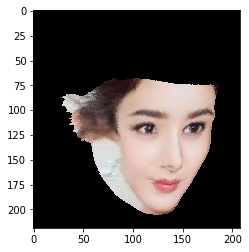

In [26]:
img_3D = np.zeros_like(img,dtype=np.uint8)
mask = np.zeros_like(img,dtype=np.uint8)
fill_area=0
for i in range(triangles.shape[0]):
    cnt = np.array([(rotated_vertices[triangles[i,0],0],rotated_vertices[triangles[i,0],1]),
           (rotated_vertices[triangles[i,1],0],rotated_vertices[triangles[i,1],1]),
           (rotated_vertices[triangles[i,2],0],rotated_vertices[triangles[i,2],1])],dtype=np.int32)
    mask = cv2.drawContours(mask,[cnt],0,(255,255,255),-1)
    if(np.sum(mask[...,0])>fill_area):
        fill_area = np.sum(mask[...,0])
        img_3D = cv2.drawContours(img_3D,[cnt],0,tri_tex[i],-1)
plt.imshow(img_3D)